# EDA

## Environment

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/notebooks'):
    main_path = p[:-len('/notebooks')]
if sys.path[0].endswith('/techdoc/content'):
    main_path = p[:-len('/techdoc/content')]
    
# Windows OS
if sys.path[0].endswith('\\notebooks'): 
    main_path = p[:-len('\\notebooks')]
if sys.path[0].endswith('\\techdoc\content'): 
    main_path = p[:-len('\\techdoc\content')]

sys.path[0] = main_path

In [3]:
import gc, itertools
from termcolor import colored
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from src import (config, describe_data, features,
                 preprocess, training)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Load the Data

In [4]:
metadata = pd.read_csv(config.DATA_DIR + 'metadata.csv')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

valid_labels = pd.read_csv(config.DATA_DIR + 'val_labels.csv')
print(f'Train labels: {valid_labels.shape}')

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

Metadata: (1570, 5)
Train labels: (766, 11)
Train labels: (293, 11)
Submission: (804, 11)


In [5]:
# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
# Train & Valid files
trva_files = train_files.copy()
trva_files.update(valid_files)
# All files
all_test_files = valid_files.copy()
all_test_files.update(test_files)

ion_list = list(np.arange(0,100,1.0))
ion_list.remove(4.0)

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']


In [6]:
train = metadata[metadata.split == 'train'].copy().reset_index(drop=True)
print(f'TRAIN: {train.shape}')
valid = metadata[metadata.split == 'val'].copy().reset_index(drop=True)
print(f'VALID: {valid.shape}')
test = metadata[metadata.split == 'test'].copy().reset_index(drop=True)
print(f'TEST: {test.shape}')

TRAIN: (766, 5)
VALID: (293, 5)
TEST: (511, 5)


# EXPLORATORY DATA ANALYSIS

## Instrument type

What proportion of instrument type do we have in the train, valid, and test samples? We get the column percentages with `pd.crosstab()` function and the argument `normalize='index'` to get the percentage by rows. We can see from the table below that the most commercial instrument is present in the train set, while in the majority of the SAM measurments are in the test set. Interestingly, there are no SAM measurements in the `val` dataset.

> In this competition, it is expected that modeling the SAM testbed data will be difficult, and that there will need to be transfer learning from the commercial instrument data in order to successfully model the SAM testbed data. 

> The top performers on the SAM testbed samples within the test set will be invited to submit a report of their methodology, to be judged by a panel of experts from NASA. 
([Ref](https://www.drivendata.co/blog/mars-spectrometry-benchmark/))

In [ ]:
#TODO Define the testing of the model on the whole sample using the CV and then separately on the commercial vs SAM instrument.  
#TODO Can it be done to model on commercial only and do a transfer learning on the SAM instrument.

In [7]:
pd.crosstab(metadata.split, metadata.instrument_type, margins=True)

instrument_type,commercial,sam_testbed,All
split,,,
test,447,64,511
train,754,12,766
val,293,0,293
All,1494,76,1570


In [8]:
pd.crosstab(metadata.split, metadata.instrument_type, normalize='index')

instrument_type,commercial,sam_testbed
split,,
test,0.874755,0.125245
train,0.984334,0.015666
val,1.000000,0.000000


In [13]:
# Combine target labels in a list for each sample
labels_list = {}
for i in train_labels.index:
    ht = pd.DataFrame(train_labels.iloc[i][target_labels_list] == 1)
    labels_list[i] = ht[ht[i] == True].index.values

# Map back to the initial table
train_labels['target'] = train_labels.index.map(labels_list)

## Exploring Features

### Time vs. Temperature

- temperature is suppose to be a function of time in the experiments
- patterns of ions may vary as a function of both time and temperature
- instrument type may contain different ranges of times and temperatures

In [ ]:
#TODO how to incorporate the fact that testbeds has some non-linear heating profiles...
# there may be nuances to how the sample was heated over time that provides additional information.

Let's visually explore the relationship between `time` and `temperature` for both types of instruments. We will pick at random 5 samples for each and plot them.

In [9]:
# Randomly select 5 samples from each instrument
sample_com = metadata[(metadata.instrument_type == 'commercial') & (metadata.split == 'train')]['sample_id'].sample(n=5).index
sample_sam = metadata[(metadata.instrument_type == 'sam_testbed') & (metadata.split == 'train')]['sample_id'].sample(n=5).index

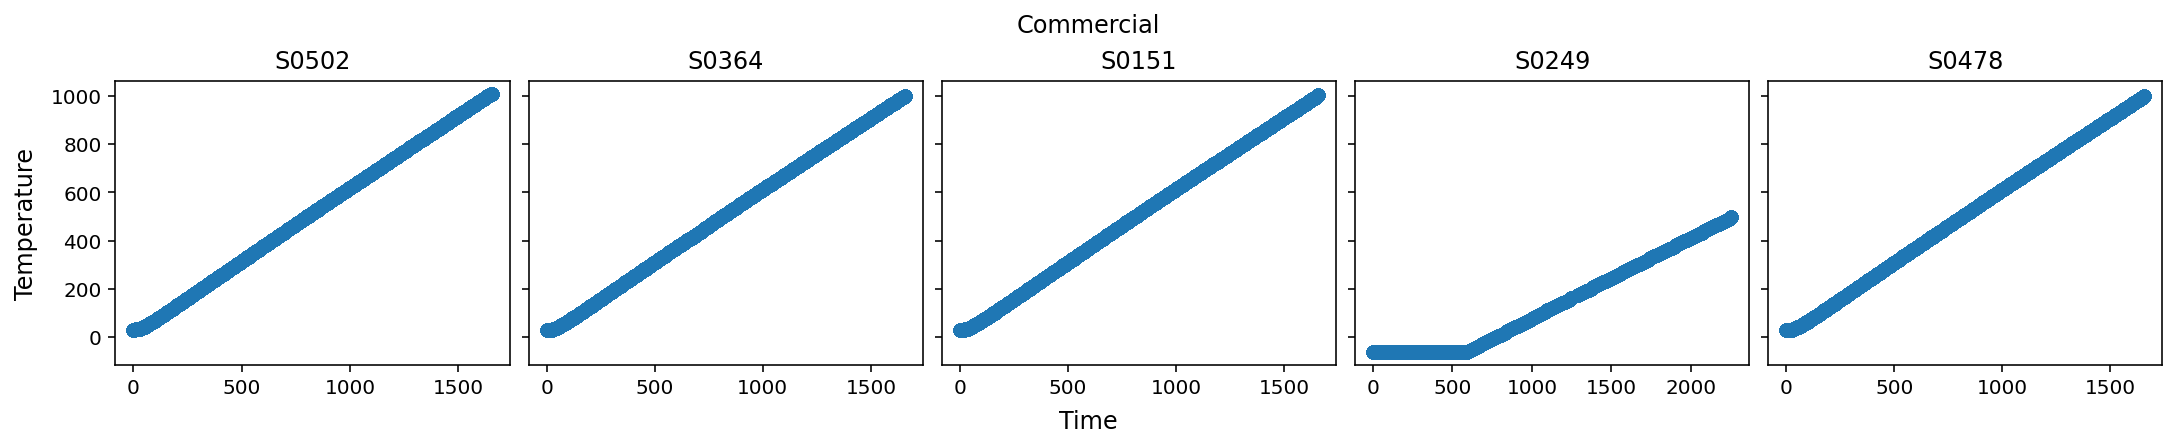

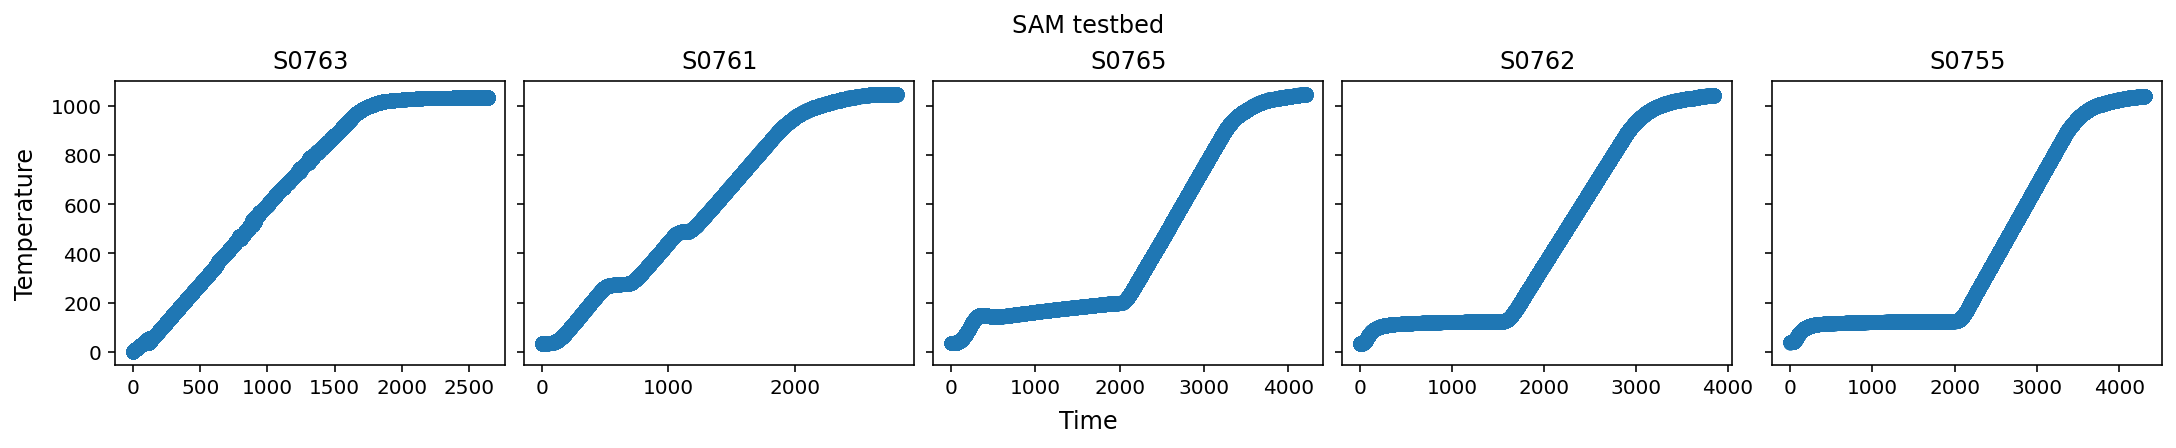

In [10]:
fig, ax = plt.subplots(1, len(sample_com), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Temperature')
fig.supxlabel('Time')
fig.suptitle('Commercial')

for n,i in enumerate(sample_com):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    plt.scatter(df['time'], df['temp'])
    plt.title(sample_name)
plt.show()
    
fig, ax = plt.subplots(1, len(sample_sam), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Temperature')
fig.supxlabel('Time')
fig.suptitle('SAM testbed')

for n,i in enumerate(sample_sam):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    plt.scatter(df['time'], df['temp'])
    plt.title(sample_name)
plt.show()
    

From the graphs above we can see that the sample have similar structure of temperature increase given time, where the max values is about 1000 degrees over a period of 1600 seconds. However, we can see that there is a difference in structure between the two instruments, where the SAM testbed has more of a non-linear structure.

### Type of Ion vs Abundance

Type of ion is given by `m/z` where the abundance, or the ion's type levels across time and temperature, is given by `abundance`. Let's try to visualize the abundance by the type of ions given temperature.

- different ion types peak at different temperatures
- there are some ions that are constantly high is value -> `m/z=4` helium carrier gas (not from the sample)
- there are ion types consistently in low value - likely background abundances and should be neglected.

> Spectrogram is useful for the peaks in abundances it shows at different temperatures and times.

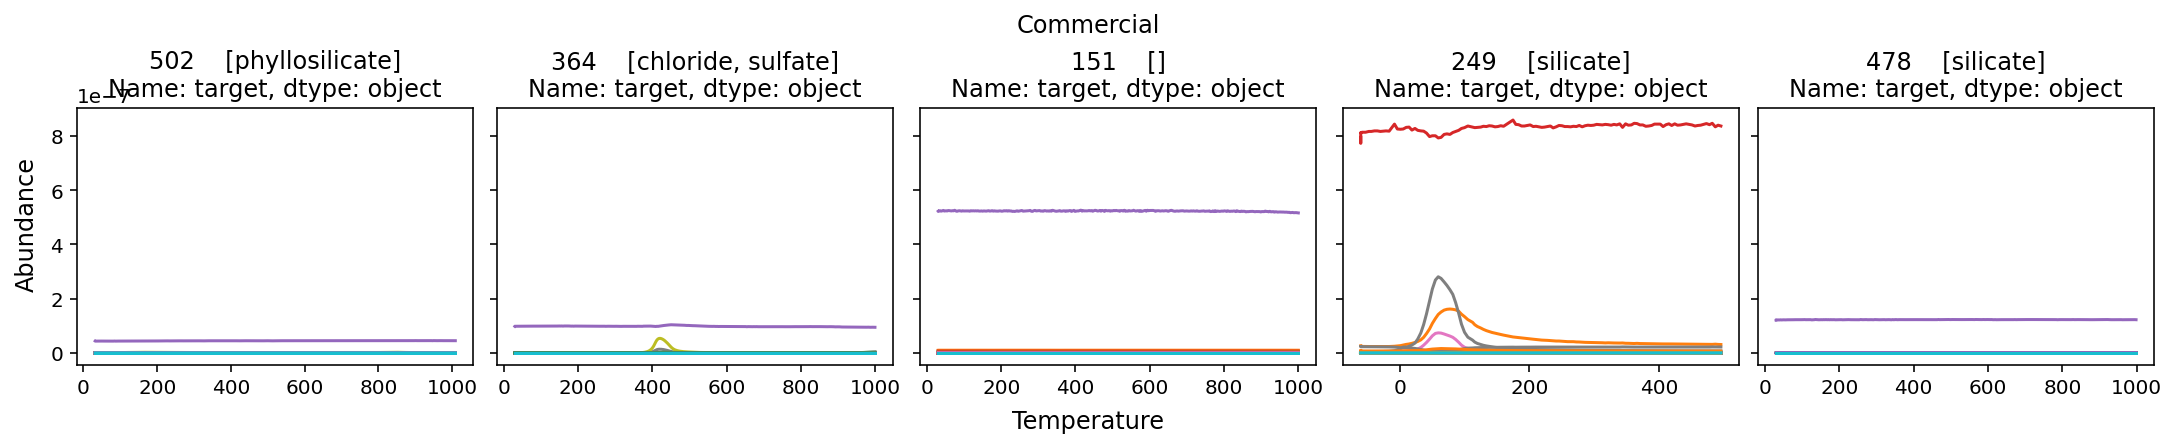

KeyboardInterrupt: 

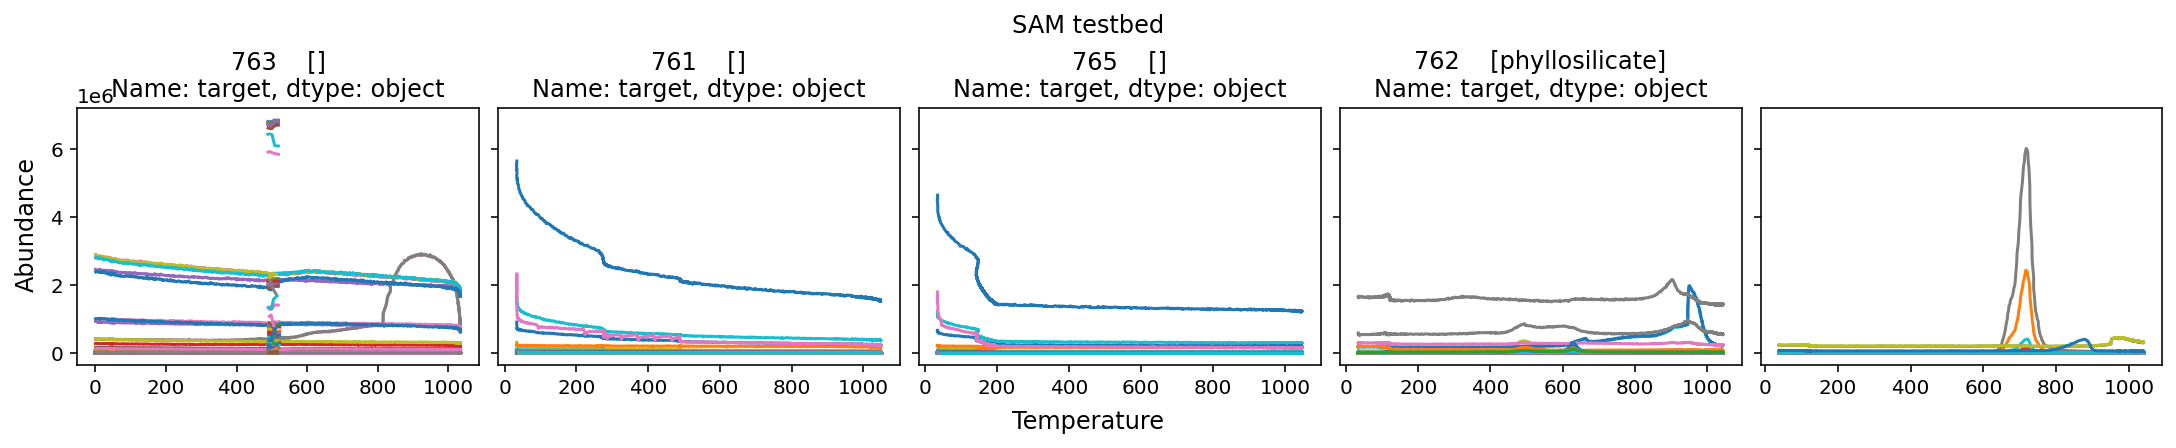

In [14]:
fig, ax = plt.subplots(1, len(sample_com), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Abundance')
fig.supxlabel('Temperature')
fig.suptitle('Commercial')

for n,i in enumerate(sample_com):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    for i in df['m/z'].unique():
        ht = df[df['m/z'] == i]
        plt.plot(ht['temp'], ht['abundance'])
    plt.title(str(target))
plt.show()

del ht

fig, ax = plt.subplots(1, len(sample_sam), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Abundance')
fig.supxlabel('Temperature')
fig.suptitle('SAM testbed')

for n,i in enumerate(sample_sam):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    for i in df['m/z'].unique():
        ht = df[df['m/z'] == i]
        plt.plot(ht['temp'], ht['abundance'])
    plt.title(str(target))
plt.show()
    

Plot the average abundance per type of ions `m/z`.

In [ ]:
#TODO Add labels for ion types greater than some value
#TODO How ions compare to the helium carrier gas

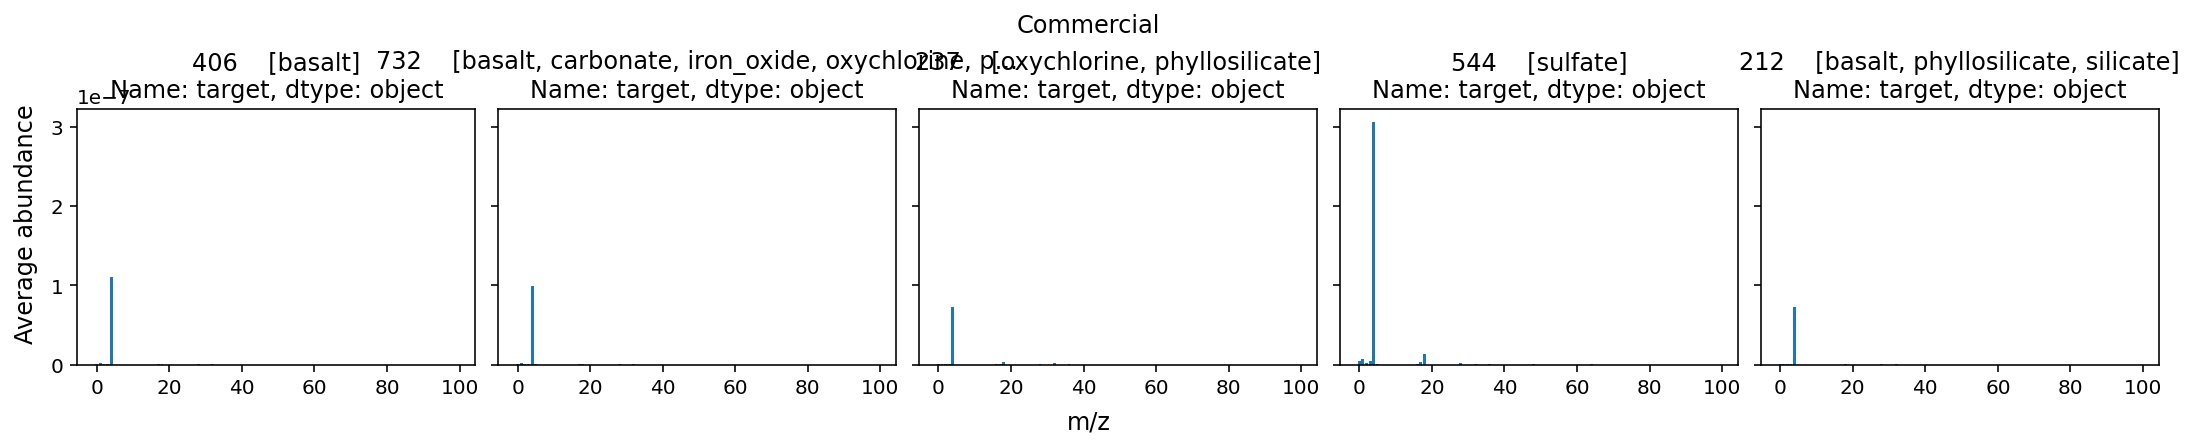

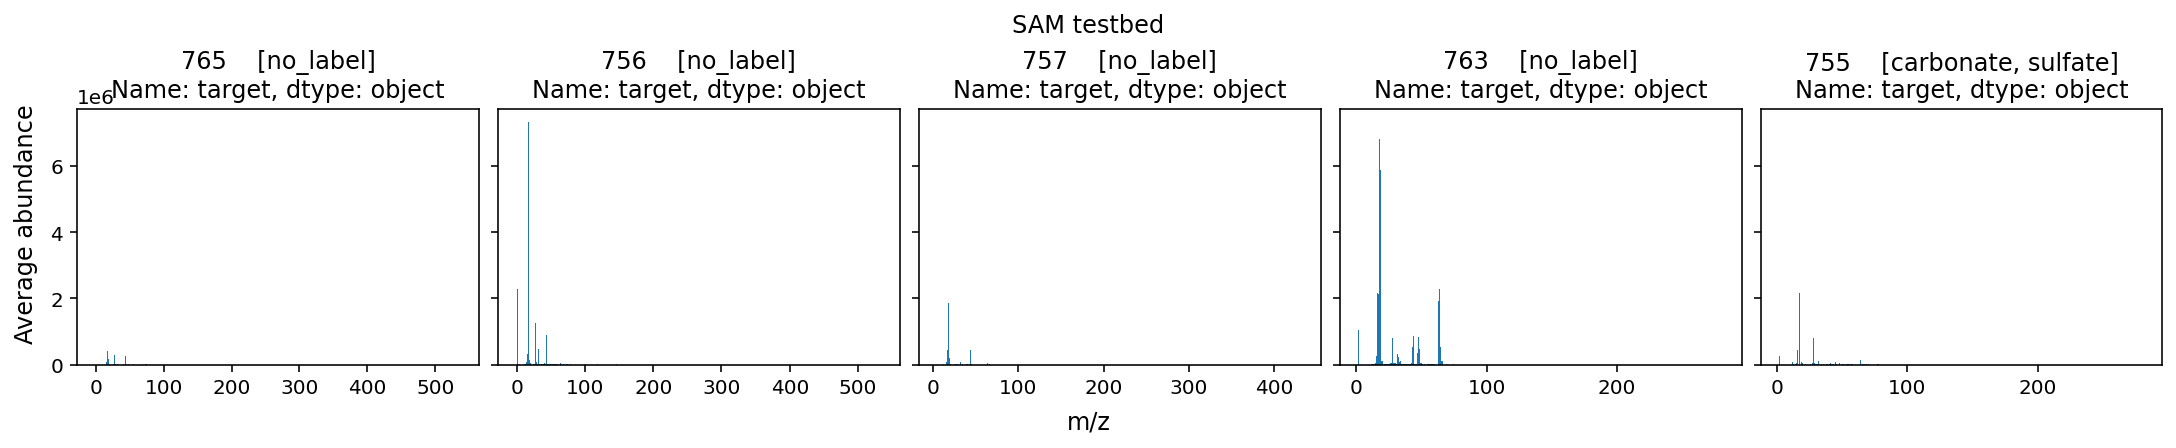

In [ ]:
fig, ax = plt.subplots(1, len(sample_com), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Average abundance')
fig.supxlabel('m/z')
fig.suptitle('Commercial')

for n,i in enumerate(sample_com):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    abd_sum = pd.DataFrame(df.groupby('m/z')['abundance'].agg('mean')).reset_index()
    plt.bar(abd_sum['m/z'], abd_sum['abundance'])
    plt.title(str(target))
plt.show()

fig, ax = plt.subplots(1, len(sample_sam), 
                       figsize=(15,3),
                       constrained_layout=True, 
                       sharey="all")
fig.supylabel('Average abundance')
fig.supxlabel('m/z')
fig.suptitle('SAM testbed')

for n,i in enumerate(sample_sam):
    # Get the file path
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    target = train_labels[train_labels.sample_id == sample_name]['target']
    
    # Read in the data
    df = pd.read_csv(config.DATA_DIR + sample_file)
    plt.subplot(1, 5, n+1)
    abd_sum = pd.DataFrame(df.groupby('m/z')['abundance'].agg('mean')).reset_index()
    plt.bar(abd_sum['m/z'], abd_sum['abundance'])
    plt.title(str(target))
plt.show()
    

`m/z` values (from the benchmark notebook):
-  the range is not the same for all samples
- most samples are in the range on (0,99) -> discard m/z with the values above 99
- SAM testbeds samples contain fractional m/z values -> drop them as well
- `m/z=4` corresponds to the helium carrier gas (*A more sophisticated analysis could potentially use it to understand how other ions compare to it relatively.*)

In the following code we compute the range of the `m/z` values for each sample. We can see from the output that the majority of the samples have ion types in the range (0,99). Also, we can see that there are some fractional values and they are close to the integer values.

In [ ]:
NO_SAMPLES = metadata.sample_id.nunique()
print(f'Number of samples = {NO_SAMPLES}')

cnt_mz_sample = {}
for i in range(NO_SAMPLES):
    sample_file = metadata.iloc[i]['features_path']
    sample_name = metadata.iloc[i]['sample_id']
    df = pd.read_csv(config.DATA_DIR + sample_file)
    cnt_mz_sample[sample_name] = pd.Interval(df['m/z'].min(), df['m/z'].max(), closed='both')
    
metadata['range_mz'] = metadata['sample_id'].map(cnt_mz_sample)

metadata['range_mz'].value_counts()

Number of samples = 1570


[0.0, 99.0]      1211
[0.0, 199.0]      161
[1.0, 60.0]        64
[2.0, 94.0]        48
[1.9, 281.0]       40
[5.0, 433.0]       11
[0.0, 534.0]        7
[0.0, 537.0]        6
[4.0, 64.0]         5
[14.0, 147.0]       3
[2.0, 64.0]         3
[13.9, 147.0]       3
[1.9, 147.0]        2
[5.0, 207.0]        2
[4.0, 78.0]         1
[4.0, 44.0]         1
[26.0, 197.0]       1
[1.9, 150.0]        1
Name: range_mz, dtype: int64

## Slope Analysis

In [78]:
i = 765
# Get data sample
hts = preprocess.get_sample(metadata, i)
hts = preprocess.preprocess_samples(hts)

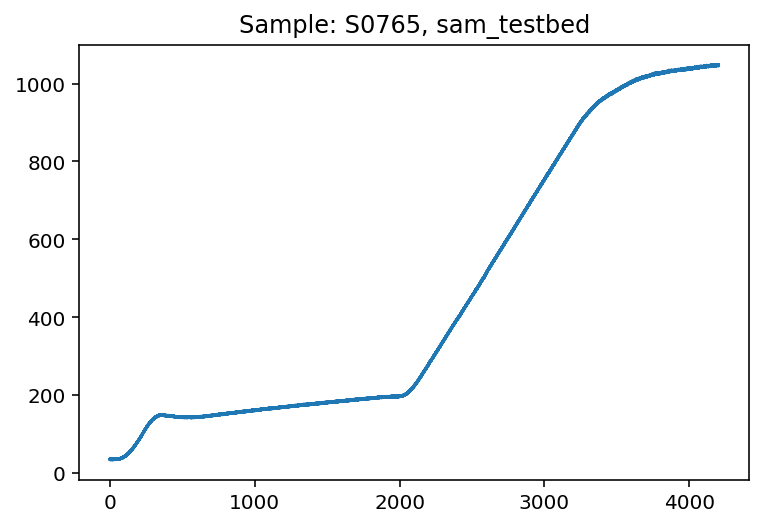

In [79]:
plt.plot(hts['time'], hts['temp'])
plt.title(f'Sample: {metadata.iloc[i]["sample_id"]}, {metadata.iloc[i]["instrument_type"]}')
plt.show()

In [43]:
slope_time_temp = features.slope_time_temp(trva_files, metadata)

100%|██████████| 1059/1059 [01:19<00:00, 13.38it/s]


In [80]:
ht = metadata.iloc[:len(trva_files),:][['sample_id', 'instrument_type']].copy()
ht['slope_tt'] = ht['sample_id'].map(slope_time_temp)
ht.head()

,sample_id,instrument_type,slope_tt
0,S0000,commercial,0.195083
1,S0001,commercial,0.167294
2,S0002,commercial,0.601609
3,S0003,commercial,0.609247
4,S0004,commercial,0.613325


In [81]:
ht.groupby('instrument_type')['slope_tt'].agg('mean')

instrument_type
commercial     0.580422
sam_testbed    0.422096
Name: slope_tt, dtype: float64

In [82]:
ht.groupby('instrument_type')['slope_tt'].agg('median')

instrument_type
commercial     0.608901
sam_testbed    0.500758
Name: slope_tt, dtype: float64

There is a difference in slopes between the two instruments. Let's add this as a feature.

## Target encoding - instrument type

Analyze target encoding based on the instrument type.

In [146]:
ht = metadata[metadata.split.isin(['train', 'val'])][['sample_id','instrument_type']].copy()
ht_y = pd.concat([train_labels, valid_labels], axis = 0).reset_index(drop=True)
assert all(ht.index == ht_y.index)
assert ht_y.shape[0] == ht.shape[0]
temp = pd.merge(ht, ht_y, on='sample_id', how='left')

temp, le_dict = features.label_encode_multi(temp, 'instrument_type', target_labels_list)
temp

,sample_id,instrument_type,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,...,le_basalt,le_carbonate,le_chloride,le_iron_oxide,le_oxalate,le_oxychlorine,le_phyllosilicate,le_silicate,le_sulfate,le_sulfide
0,S0000,commercial,0,0,0,0,0,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
1,S0001,commercial,0,1,0,0,0,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
2,S0002,commercial,0,0,0,0,0,1,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
3,S0003,commercial,0,1,0,1,0,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
4,S0004,commercial,0,0,0,1,0,1,1,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,S1054,commercial,0,0,0,0,0,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
1055,S1055,commercial,0,0,0,0,0,0,0,1,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
1056,S1056,commercial,0,0,0,0,1,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468
1057,S1057,commercial,0,1,0,0,0,0,0,0,...,0.116523,0.126074,0.126074,0.221585,0.04107,0.228271,0.326648,0.133715,0.200573,0.0468


In [150]:
temp['le_carbonate'].value_counts()

0.126074    1047
0.083334      12
Name: le_carbonate, dtype: int64

# Analyze mass Spectrum

## `oxalate`

https://spectrabase.com/spectrum/DHc77L5NLkT

In [22]:
oxalate = train_labels[train_labels['oxalate'] == 1].index
oxalate


Int64Index([  5,  20,  59,  74,  79, 114, 120, 137, 139, 156, 222, 259, 265,
            274, 335, 336, 423, 448, 451, 496, 503, 515, 533, 613, 619, 633,
            643, 675, 677, 737],
           dtype='int64')

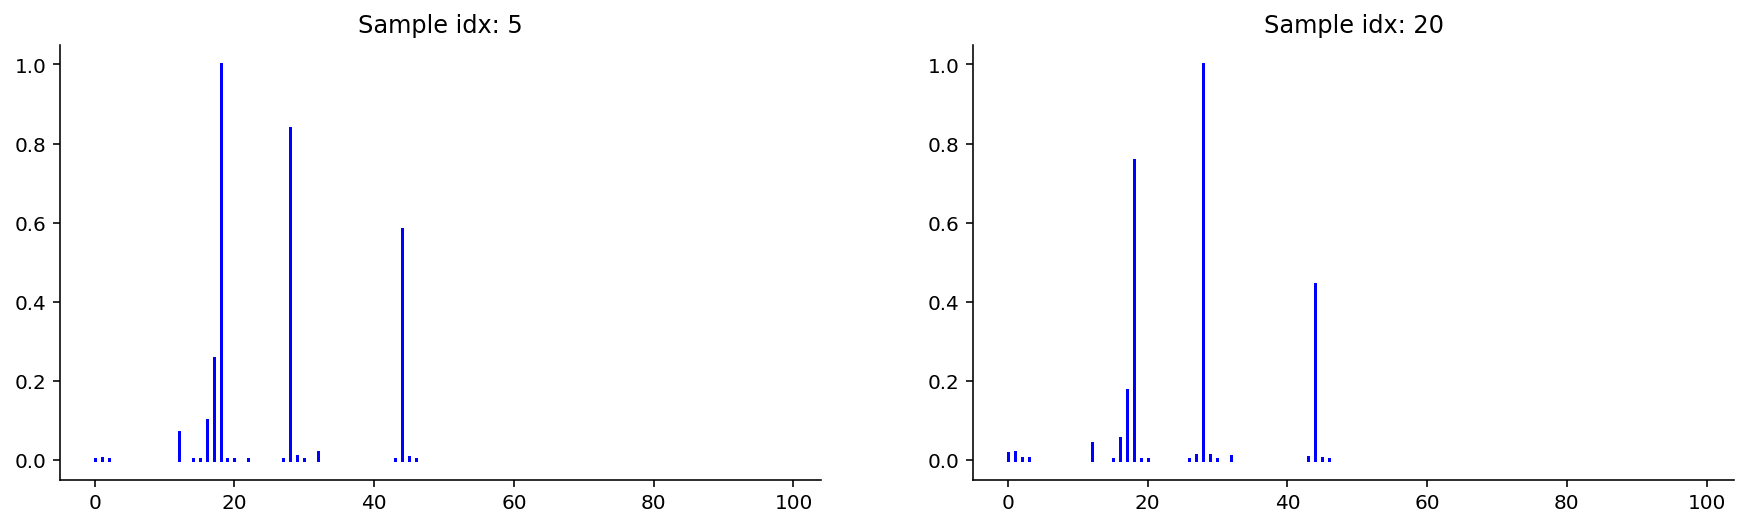

In [37]:
no_plots = 2
_,_ = plt.subplots(1,no_plots, figsize=(15,4))
for n in range(no_plots):
    
    i = oxalate[n]
    
    # Get data sample
    hts = preprocess.get_sample(metadata, i)
    hts = preprocess.preprocess_samples(hts)

    max_abund_ion = {}
    for ion in ion_list:
        temp = hts[hts['m/z'] == ion]
        max_abund_ion[ion] = temp['abun_minsub_scaled'].max()
    
    # Sample median of abundance
    #abund_median = hts['abun_minsub_scaled'].mean()
    
    plt.subplot(1,no_plots,n+1)
    plt.title(f'Sample idx: {i}')
    #[mz,mz],[0,peak]
    for ion in ion_list:
        y = max_abund_ion[ion]
        plt.plot([ion,ion], [0,y], c='blue')
    #plt.plot([0,100], [abund_median, abund_median], c='orange')
    sns.despine()
plt.show()

## `basalt`

In [78]:
basalt = train_labels[train_labels['basalt'] == 1].index


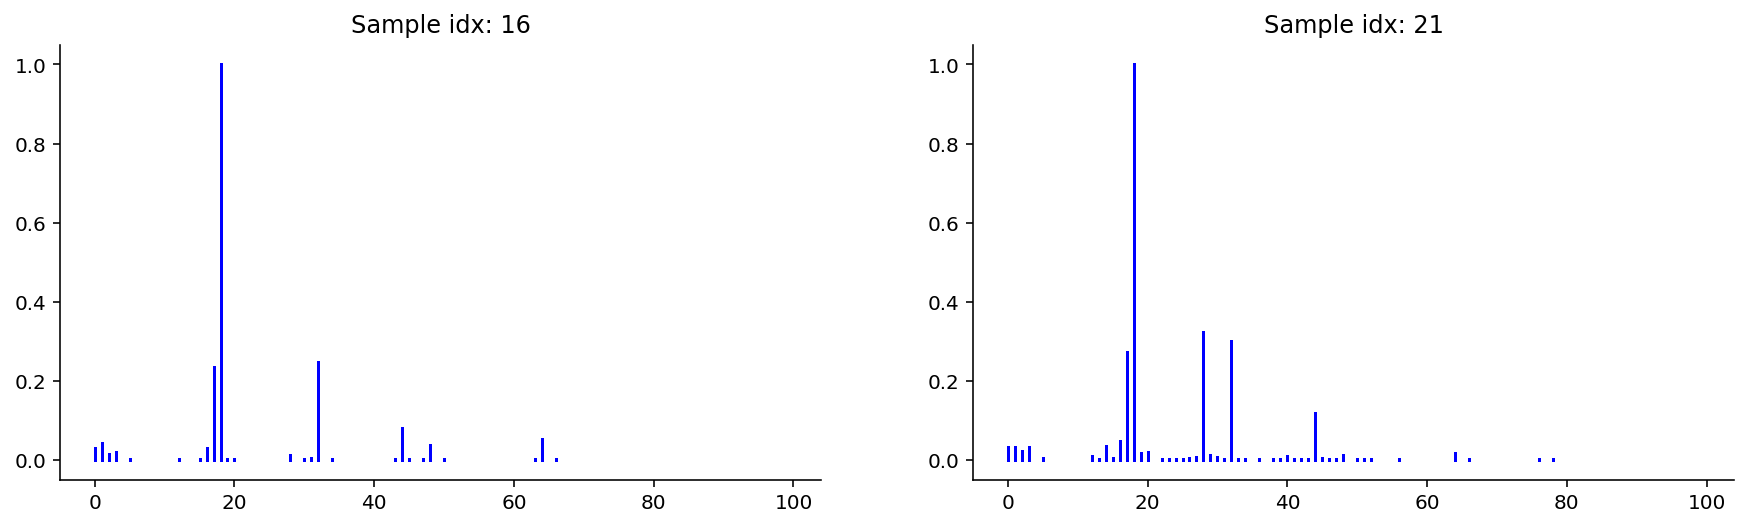

In [77]:
no_plots = 2
_,_ = plt.subplots(1,no_plots, figsize=(15,4))
for n in range(no_plots):
    
    i = basalt[n]
    
    # Get data sample
    hts = preprocess.get_sample(metadata, i)
    hts = preprocess.preprocess_samples(hts)

    max_abund_ion = {}
    for ion in ion_list:
        temp = hts[hts['m/z'] == ion]
        max_abund_ion[ion] = temp['abun_minsub_scaled'].max()
    
    # Sample median of abundance
    #abund_median = hts['abun_minsub_scaled'].mean()
    
    plt.subplot(1,no_plots,n+1)
    plt.title(f'Sample idx: {i}')
    #[mz,mz],[0,peak]
    for ion in ion_list:
        y = max_abund_ion[ion]
        plt.plot([ion,ion], [0,y], c='blue')
    #plt.plot([0,100], [abund_median, abund_median], c='orange')
    sns.despine()
plt.show()

In [75]:
hts = preprocess.get_sample(metadata, 20)
hts = preprocess.preprocess_samples(hts)
print(hts[hts['m/z'] == 0.0]['abun_minsub_scaled'].max())
list((hts.groupby('m/z')['abun_minsub_scaled'].agg('max').sort_values(ascending=False)).head(3).index)

0.017149621845516435


[28.0, 18.0, 44.0]

# TOP N ions based on max relative abundance

In [15]:
top3_ions = features.get_topN_ions(metadata, N=3)
top3_ions.head()

100%|██████████| 1570/1570 [01:54<00:00, 13.72it/s]


,top_1,top_2,top_3
S0000,0.18,0.17,0.16
S0001,0.44,0.16,0.02
S0002,0.18,0.32,0.17
S0003,0.18,0.44,0.17
S0004,0.18,0.32,0.17


In [16]:
print(list(top3_ions.top_1.unique()))

[0.18, 0.43999999999999995, 0.32, 0.27999999999999997, 0.64, 0.02, 0.3, 0.0, 0.16999999999999998, 0.43, 0.26999999999999996]


In [17]:
temp = top3_ions.iloc[:train.shape[0],:].copy()
temp = pd.concat([temp, train_labels.set_index('sample_id')], axis = 1)
temp.head()

,top_1,top_2,top_3,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
S0000,0.18,0.17,0.16,0,0,0,0,0,0,0,0,1,0
S0001,0.44,0.16,0.02,0,1,0,0,0,0,0,0,0,0
S0002,0.18,0.32,0.17,0,0,0,0,0,1,0,0,0,0
S0003,0.18,0.44,0.17,0,1,0,1,0,0,0,0,1,0
S0004,0.18,0.32,0.17,0,0,0,1,0,1,1,0,0,0


In [18]:
temp = temp.drop(['top_2', 'top_3'], axis = 1)
tempm = pd.melt(temp, id_vars='top_1', value_vars=target_labels_list)
tempm = tempm[tempm.value == 1]

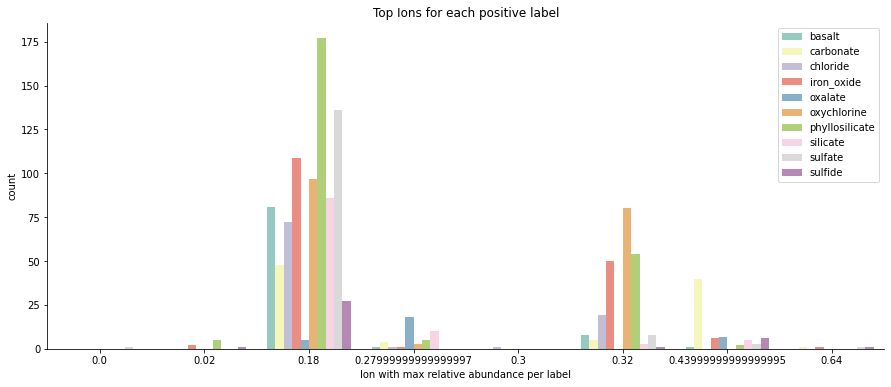

In [19]:
_,_ = plt.subplots(1,1,figsize=(15,6))
sns.countplot(x='top_1', data=tempm, hue='variable', palette="Set3")
plt.title('Top Ions for each positive label')
plt.xlabel('Ion with max relative abundance per label')
plt.legend()
sns.despine()
plt.show()

# Target encoding for top ions

- Separate for instruments

In [20]:
temp = top3_ions.iloc[:train.shape[0],:].copy()
temp = pd.concat([temp, train_labels.set_index('sample_id')], axis = 1)
print(temp.shape)
temp.head()

(766, 13)


,top_1,top_2,top_3,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
S0000,0.18,0.17,0.16,0,0,0,0,0,0,0,0,1,0
S0001,0.44,0.16,0.02,0,1,0,0,0,0,0,0,0,0
S0002,0.18,0.32,0.17,0,0,0,0,0,1,0,0,0,0
S0003,0.18,0.44,0.17,0,1,0,1,0,0,0,0,1,0
S0004,0.18,0.32,0.17,0,0,0,1,0,1,1,0,0,0


In [21]:
# TOP = 1
df = pd.DataFrame(index=list(temp.top_1.unique()))
for label in target_labels_list:
    le = features.label_encode(temp, 'top_1', label)
    df = pd.concat([df, le], axis=1, ignore_index=False)
cm = sns.light_palette("green", as_cmap=True)
df.style.background_gradient(cmap=cm, axis = 1)

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0.180000,0.153992,0.091255,0.136882,0.207224,0.009506,0.184411,0.336502,0.163498,0.258555,0.051331
0.440000,0.017544,0.701754,0.000000,0.105263,0.122807,0.000000,0.035088,0.087719,0.052632,0.105263
0.320000,0.067227,0.042017,0.159664,0.420168,0.000000,0.672269,0.453782,0.025210,0.067227,0.008403
0.280000,0.020408,0.081633,0.020408,0.020408,0.367347,0.061224,0.102041,0.204082,0.000000,0.000000
0.640000,0.031950,0.399937,0.032652,0.424865,0.010533,0.063198,0.085317,0.036514,0.417843,0.378169
0.020000,0.000015,0.000016,0.000015,0.200003,0.000005,0.000029,0.499977,0.000017,0.000024,0.099993
0.300000,0.059399,0.063969,0.560705,0.110313,0.019582,0.117493,0.158616,0.067885,0.097258,0.023499
0.000000,0.059399,0.063969,0.060705,0.110313,0.019582,0.117493,0.158616,0.067885,0.597258,0.023499
0.170000,0.059399,0.063969,0.060705,0.110313,0.019582,0.117493,0.158616,0.067885,0.097258,0.023499


In [22]:
# TOP = 2
df = pd.DataFrame(index=list(temp.top_2.unique()))
for label in target_labels_list:
    le = features.label_encode(temp, 'top_2', label)
    df = pd.concat([df, le], axis=1, ignore_index=False)
cm = sns.light_palette("blue", as_cmap=True)
df.style.background_gradient(cmap=cm, axis = 1)

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0.170000,0.125000,0.071970,0.151515,0.193182,0.000000,0.087121,0.356061,0.090909,0.325758,0.018939
0.160000,0.080000,0.420000,0.060000,0.120000,0.000000,0.500000,0.200000,0.060000,0.060000,0.040000
0.320000,0.200000,0.133333,0.158974,0.215385,0.000000,0.343590,0.343590,0.276923,0.138462,0.061538
0.440000,0.166667,0.095238,0.023810,0.119048,0.166667,0.119048,0.309524,0.166667,0.214286,0.023810
0.280000,0.090909,0.386364,0.022727,0.136364,0.250000,0.068182,0.090909,0.068182,0.113636,0.000000
0.020000,0.000000,0.045455,0.000000,0.272727,0.000000,0.000000,0.272727,0.272727,0.000000,0.090909
0.180000,0.033613,0.058824,0.126050,0.394958,0.100840,0.470588,0.411765,0.042017,0.050420,0.050420
0.640000,0.000000,0.000000,0.000000,0.333333,0.000000,0.066667,0.000000,0.000000,0.533333,0.466666
0.120000,0.059399,0.063969,0.060705,0.110313,0.019582,0.117493,0.158616,0.567885,0.097258,0.023499
0.010000,0.000795,0.331959,0.000813,0.001477,0.000262,0.001573,0.002123,0.000909,0.001302,0.000315


In [23]:
# TOP = 3
df = pd.DataFrame(index=list(temp.top_2.unique()))
for label in target_labels_list:
    le = features.label_encode(temp, 'top_3', label)
    df = pd.concat([df, le], axis=1, ignore_index=False)
cm = sns.light_palette("orange", as_cmap=True)
df.style.background_gradient(cmap=cm, axis = 1)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/pandas/io/formats/style.py:3554: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/pandas/io/formats/style.py:3555: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0.170000,0.151220,0.082927,0.151220,0.239024,0.000000,0.351220,0.341463,0.151220,0.141463,0.068293
0.160000,0.021739,0.304348,0.130435,0.304348,0.000000,0.391304,0.369565,0.021739,0.173913,0.043478
0.320000,0.163265,0.096939,0.163265,0.188776,0.010204,0.107143,0.392857,0.117347,0.285714,0.005102
0.440000,0.182927,0.182927,0.097561,0.365854,0.195122,0.304878,0.475610,0.207317,0.182927,0.024390
0.280000,0.012658,0.240506,0.063291,0.164557,0.012658,0.139241,0.240506,0.113924,0.063291,0.113924
0.020000,0.002137,0.395107,0.002184,0.003968,0.000704,0.004227,0.398511,0.198845,0.003499,0.000845
0.180000,0.074074,0.129630,0.092593,0.185185,0.203704,0.388889,0.259259,0.148148,0.055556,0.018519
0.640000,0.125000,0.041667,0.000000,0.208333,0.000000,0.041667,0.041667,0.083333,0.666667,0.166667
0.120000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0.010000,0.060606,0.090909,0.030303,0.090909,0.000000,0.121212,0.060606,0.242424,0.272727,0.000000


In [126]:
import os

In [ ]:
combo_maxabund_peaks_slope_VT.to_csv(os.path.join(config.DATA_DIR_OUT + 'combo_maxabund_peaks_slope_VT.csv'), 
                                  index=False)

In [76]:
# TRAIN ONLY
combo_maxabund_peaks_slope = pd.read_csv(os.path.join(config.DATA_DIR_OUT + 'combo_maxabund_peaks_slope.csv'))
combo_maxabund_peaks_slope_VT = pd.read_csv(os.path.join(config.DATA_DIR_OUT + 'combo_maxabund_peaks_slope_VT.csv'))
combo_maxabund_peaks_slope.head()
print(combo_maxabund_peaks_slope.shape)

(766, 1981)


**Train on only the target encoder**

In [77]:
combo_maxabund_peaks_slope.head()

,Ion_0.0_-100_0,Ion_0.0_0_100,Ion_0.0_100_200,Ion_0.0_200_300,Ion_0.0_300_400,Ion_0.0_400_500,Ion_0.0_500_600,Ion_0.0_600_700,Ion_0.0_700_800,Ion_0.0_800_900,...,peak_abund_91.0,peak_abund_92.0,peak_abund_93.0,peak_abund_94.0,peak_abund_95.0,peak_abund_96.0,peak_abund_97.0,peak_abund_98.0,peak_abund_99.0,slope_tt
0,0.0,0.004085,0.004641,0.001394,0.000188,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195083
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167294
2,0.0,0.002270,0.002495,0.001688,0.000636,0.000597,0.000819,0.000155,0.000235,0.000227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.601609
3,0.0,0.001336,0.002464,0.001099,0.000992,0.000676,0.000883,0.000892,0.000631,0.000361,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.609247
4,0.0,0.005993,0.012429,0.009380,0.005099,0.006921,0.001966,0.000499,0.000880,0.000767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.613325


In [78]:
Xtr = top3_ions.iloc[:train.shape[0],:][['top_1']].copy()
Xtr = pd.concat([combo_maxabund_peaks_slope, Xtr.reset_index(drop=True)], axis = 1)
print(Xtr.shape)

Xte = top3_ions.iloc[train.shape[0]:,:][['top_1']].copy()
Xte = pd.concat([combo_maxabund_peaks_slope_VT, Xte.reset_index(drop=True)], axis = 1)
print(Xte.shape)

(766, 1982)
(804, 1982)


In [82]:
train_cv_loss_XGB_tempb_peaks_slope_opt, train_full_clf_XGB_tempb_peaks_slope_opt, submission_XGB_tempb_peaks_slope_opt =\
    training.train_tbl(
        df_train=Xtr,
        df_labels=train_labels,
        target_list=target_labels_list,
        df_test=Xte,
        model_algo='XGB_opt',
        sub_name='XGB_tempb_peaks_slope_opt_TE',
        target_encode=True
    )

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1681
Log Loss per Label:
{'basalt': 0.19520568177743663, 'carbonate': 0.1134534250622214, 'chloride': 0.1963325934969151, 'iron_oxide': 0.24240615336086457, 'oxalate': 0.012315083744781958, 'oxychlorine': 0.16530498244485917, 'phyllosilicate': 0.2337752354408003, 'silicate': 0.23266904940951322, 'sulfate': 0.2139509943589905, 'sulfide': 0.07531181614802744}


In [85]:
train_cv_loss_XGB_tempb_peaks_slope_opt

{'basalt': 0.19520568177743663,
 'carbonate': 0.1134534250622214,
 'chloride': 0.1963325934969151,
 'iron_oxide': 0.24240615336086457,
 'oxalate': 0.012315083744781958,
 'oxychlorine': 0.16530498244485917,
 'phyllosilicate': 0.2337752354408003,
 'silicate': 0.23266904940951322,
 'sulfate': 0.2139509943589905,
 'sulfide': 0.07531181614802744}

In [89]:
print(f'Average Log Loss: {np.mean(list(train_cv_loss_XGB_tempb_peaks_slope_opt.values()))}')

Average Log Loss: 0.16807250152444103
